## Cycling Infrastructure Data

Looking deep into the cycling infrastructure

In [1]:
# import libraries

import os
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

### Cycle lanes

In [2]:
cycle_lane = gpd.read_file('data/cycle_lane_track.json').to_crs('EPSG:27700')

In [3]:
# cycle routes
cycle_routes = gpd.read_file('data/cycling_infrastructure/CycleRoutes.json').to_crs('EPSG:27700')
cycle_routes['route_length'] = cycle_routes.length

In [4]:
cycle_routes.head(5)

,OBJECTID,Label,Route_Name,Status,Programme_,Programme,Shape_Leng,geometry,route_length
0,158,C4,Cycleway 4,Planned,20230911,Cycleways,2348.530394,"LINESTRING Z (541134.847 178508.841 0.000, 541...",2348.584515
1,159,C4,Cycleway 4,Planned,20230911,Cycleways,1283.879923,"LINESTRING Z (543232.390 179208.806 0.000, 543...",1283.896516
2,160,C,Cycleway,Planned,20230911,Cycleways,3174.451922,MULTILINESTRING Z ((539675.083 185036.217 0.00...,3174.397267
3,161,C40,Cycleway,In Progress,20230911,Cycleways,5443.856227,MULTILINESTRING Z ((517898.492 180916.076 0.00...,5443.929194
4,162,C5,Cycleway 5,Open,20230911,Cycleways,8523.614504,MULTILINESTRING Z ((528801.849 174090.515 0.00...,8523.737104


<Axes: >

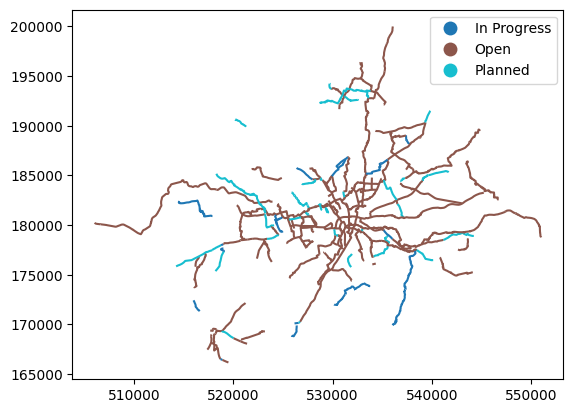

In [5]:
cycle_routes.plot(
    column = 'Status',
    legend = True
)

In [6]:
cycle_lane['road_length'] = cycle_lane.length

In [7]:
cycle_lane.dtypes

FEATURE_ID       object
SVDATE           object
CLT_CARR         object
CLT_SEGREG       object
CLT_STEPP        object
CLT_PARSEG       object
CLT_SHARED       object
CLT_MANDAT       object
CLT_ADVIS        object
CLT_PRIORI       object
CLT_CONTRA       object
CLT_BIDIRE       object
CLT_CBYPAS       object
CLT_BBYPAS       object
CLT_PARKR        object
CLT_WATERR       object
CLT_PTIME        object
CLT_ACCESS       object
CLT_COLOUR       object
BOROUGH          object
PHOTO1_URL       object
PHOTO2_URL       object
geometry       geometry
road_length     float64
dtype: object

Index(['FEATURE_ID', 'SVDATE', 'CLT_CARR', 'CLT_SEGREG', 'CLT_STEPP',
       'CLT_PARSEG', 'CLT_SHARED', 'CLT_MANDAT', 'CLT_ADVIS', 'CLT_PRIORI',
       'CLT_CONTRA', 'CLT_BIDIRE', 'CLT_CBYPAS', 'CLT_BBYPAS', 'CLT_PARKR',
       'CLT_WATERR', 'CLT_PTIME', 'CLT_ACCESS', 'CLT_COLOUR', 'BOROUGH',
       'PHOTO1_URL', 'PHOTO2_URL', 'geometry', 'road_length'],
      dtype='object')

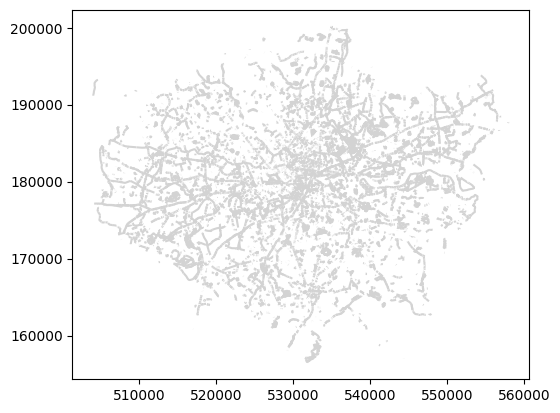

In [8]:
cycle_lane.plot(
    color = 'lightgray'
)

cycle_lane.columns

#### Summary Statistics

Calculate the summary statistics for cycle lane

In [9]:
# summary statistics

cycle_lane.length


0         134.240613
1          85.310122
2         251.131588
3         142.592121
4          24.695457
            ...     
24971     562.460493
24972      45.089943
24973    6558.899125
24974      38.864592
24975     254.639478
Length: 24976, dtype: float64

### Points Data

The data we have from the TfL cycling infrastructure

- `cycle_parking.json`
- `restricted_point.json`
- `signage.json`
- `signal.json`
- `traffic_calming.json`



In [10]:
# # load points data
# cycle_parking = gpd.read_file('data/cycling_infrastructure/cycle_parking.json').to_crs('EPSG:27700')
# restricted_point = gpd.read_file('data/cycling_infrastructure/restricted_point.json').to_crs('EPSG:27700')
# signage = gpd.read_file('data/cycling_infrastructure/signage.json').to_crs('EPSG:27700')
# signal = gpd.read_file('data/cycling_infrastructure/signal.json').to_crs('EPSG:27700')
# traffic_calming = gpd.read_file('data/cycling_infrastructure/traffic_calming.json').to_crs('EPSG:27700')

### Road network

Roads from OS open roads

In [11]:
roads = gpd.read_file('data/london_roads.gpkg')

## Cycling Traffic

The cycling traffic, measured in 2 different ways: active travel counts and DfT traffic data.



### Active travel count

Not using this for analysis!!!

In [12]:
# load data

atc_path = os.path.join('data', 'active_travel_counts')
fn = ['2022 W1 spring-Central.csv', '2022 W1 spring-Inner-Part1.csv', '2022 W1 spring-Inner-Part2.csv', '2022 W1 spring-Outer.csv', '2022 W1 spring-Cycleways.csv']

traffic_df = []
for f in fn:
    traffic_df.append(
        pd.read_csv(os.path.join(atc_path,f))
    )

traffic_concat = pd.concat(traffic_df)


In [13]:
# drop NA values
traffic_concat.Path.dropna(inplace = True)

In [14]:
traffic_concat.Mode.unique()

array(['Cargo bikes', 'Conventional cycles', 'E-scooters', 'Pedestrians',
       'Cycle hire bikes', 'Private cycles', 'Cycles', 'Male cyclists',
       'Female cyclists', 'Unknown cyclists'], dtype=object)

In [15]:
traffic_by_points = pd.DataFrame(traffic_concat[traffic_concat['Mode'] != 'Pedestrians'].groupby(['UnqID', 'Mode']).agg(
    {
        'Count': 'mean'
    }
).reset_index().groupby('UnqID')['Count'].sum()).rename(columns = {'Count': 'cycle_counts'})

In [16]:
traffic_by_points

,cycle_counts
UnqID,
ML0001,14.139062
ML0002,11.954688
ML0003,6.606250
ML0004,4.781250
ML0005,21.690104
...,...
ML2051,16.994792
ML2052,27.078125
ML2055,82.380208


In [17]:
# load locations
locations = pd.read_csv(os.path.join(atc_path, '1 Monitoring locations.csv'))
locations_gdf = gpd.GeoDataFrame(
    locations,
    geometry = gpd.points_from_xy(locations['Easting (UK Grid)'], locations['Northing (UK Grid)'], crs = 'EPSG:27700')
)

In [18]:
# get traffic by location
locations_gdf = locations_gdf.merge(
    traffic_by_points, left_on = 'Site ID', right_index = True
)

### DfT traffic data



In [19]:
london_traffic = pd.read_csv('data/london_traffic_boroughs.csv')

london_traffic

,Unnamed: 0,Local_authority_id,name,ONS_code,year,link_length_km,link_length_miles,cars_and_taxis,all_motor_vehicles
0,56,57,Barnet,E09000003,1993,729.225,453.12,8.194056e+08,9.619031e+08
1,64,66,Hillingdon,E09000017,1993,719.211,446.90,1.089714e+09,1.274280e+09
2,90,93,Tower Hamlets,E09000030,1993,282.780,175.71,4.404428e+08,5.559174e+08
3,93,96,Islington,E09000019,1993,240.063,149.17,2.390268e+08,3.011351e+08
4,100,103,Southwark,E09000028,1993,388.328,241.30,4.257460e+08,5.284653e+08
...,...,...,...,...,...,...,...,...,...
985,6114,177,Sutton,E09000029,2022,468.830,291.32,3.605919e+08,4.560344e+08
986,6115,178,Kingston upon Thames,E09000021,2022,342.960,213.11,4.683174e+08,5.890935e+08
987,6121,185,Harrow,E09000015,2022,472.260,293.45,3.172663e+08,3.890621e+08
988,6136,201,Havering,E09000016,2022,684.150,425.11,7.893772e+08,1.104040e+09


In [20]:
london_traffic_pivot = london_traffic.pivot_table(
    values = 'all_motor_vehicles',
    columns = 'year',
    index = 'ONS_code'
).add_prefix('DfT_')

london_traffic_pivot

year,DfT_1993,DfT_1994,DfT_1995,DfT_1996,DfT_1997,DfT_1998,DfT_1999,DfT_2000,DfT_2001,DfT_2002,...,DfT_2013,DfT_2014,DfT_2015,DfT_2016,DfT_2017,DfT_2018,DfT_2019,DfT_2020,DfT_2021,DfT_2022
ONS_code,,,,,,,,,,,,,,,,,,,,,
E09000001,1.240260e+08,1.263218e+08,1.265158e+08,1.298277e+08,1.324982e+08,1.347189e+08,1.344134e+08,1.315497e+08,1.268615e+08,1.216209e+08,...,9.862477e+07,1.013440e+08,1.013555e+08,9.924262e+07,9.583624e+07,9.263199e+07,9.329609e+07,7.266374e+07,7.956927e+07,7.488486e+07
E09000002,3.430461e+08,3.470355e+08,3.430952e+08,3.420780e+08,3.400271e+08,3.382416e+08,3.569110e+08,3.526342e+08,3.545453e+08,3.573560e+08,...,3.929164e+08,4.056668e+08,4.055949e+08,4.184031e+08,4.115314e+08,4.103061e+08,4.105054e+08,3.473927e+08,3.746127e+08,3.983885e+08
E09000003,9.619031e+08,9.806793e+08,9.797544e+08,9.980109e+08,1.014471e+09,1.013052e+09,1.036498e+09,1.021734e+09,1.034810e+09,1.038349e+09,...,1.090261e+09,1.102872e+09,1.097543e+09,1.088220e+09,1.116228e+09,1.114928e+09,1.132048e+09,8.996059e+08,1.005288e+09,1.023084e+09
E09000004,5.404198e+08,5.482486e+08,5.445228e+08,5.612441e+08,5.679980e+08,5.728568e+08,5.813771e+08,6.045888e+08,6.200133e+08,6.190958e+08,...,6.006944e+08,6.167879e+08,6.216875e+08,6.407191e+08,6.420157e+08,6.306800e+08,6.422622e+08,5.399976e+08,5.992312e+08,6.162734e+08
E09000005,5.647034e+08,5.721023e+08,5.673605e+08,5.820185e+08,5.797274e+08,5.945766e+08,6.083238e+08,6.158157e+08,6.137388e+08,6.327108e+08,...,5.913313e+08,6.109148e+08,5.978076e+08,6.261373e+08,6.196218e+08,6.207019e+08,6.365780e+08,5.488709e+08,5.997755e+08,5.978327e+08
E09000006,7.853778e+08,7.860926e+08,7.849865e+08,7.981329e+08,8.055403e+08,8.153160e+08,8.237797e+08,8.347979e+08,8.588904e+08,8.648366e+08,...,8.608329e+08,8.797766e+08,8.861329e+08,9.069841e+08,9.012401e+08,8.813946e+08,9.124605e+08,7.425883e+08,8.498127e+08,8.701679e+08
E09000007,3.845647e+08,3.874729e+08,3.897701e+08,3.869137e+08,3.884078e+08,3.899754e+08,3.944047e+08,3.805384e+08,3.763873e+08,3.706007e+08,...,3.089884e+08,3.132673e+08,3.127622e+08,3.158096e+08,3.126006e+08,3.036875e+08,3.002133e+08,2.436641e+08,2.705145e+08,2.765077e+08
E09000008,8.206364e+08,8.317327e+08,8.268468e+08,8.317642e+08,8.337942e+08,8.408028e+08,8.554180e+08,8.502677e+08,8.629479e+08,8.689894e+08,...,8.169563e+08,8.283882e+08,8.268003e+08,8.490742e+08,8.383382e+08,8.282874e+08,8.434897e+08,7.057423e+08,7.987716e+08,8.194500e+08
E09000009,7.858113e+08,7.947082e+08,7.855077e+08,7.991749e+08,7.983197e+08,8.002107e+08,8.583148e+08,8.651404e+08,8.699295e+08,8.752391e+08,...,8.434334e+08,8.261381e+08,8.310922e+08,8.353186e+08,8.502779e+08,8.471215e+08,8.510597e+08,7.218582e+08,7.807462e+08,8.033812e+08


In [21]:
raw_data = pd.read_csv('data/dft_traffic_counts_raw_counts.csv')

In [22]:
raw_data.head(5)

,Count_point_id,Direction_of_travel,Year,Count_date,hour,Region_id,Region_name,Region_ons_code,Local_authority_id,Local_authority_name,...,Buses_and_coaches,LGVs,HGVs_2_rigid_axle,HGVs_3_rigid_axle,HGVs_4_or_more_rigid_axle,HGVs_3_or_4_articulated_axle,HGVs_5_articulated_axle,HGVs_6_articulated_axle,All_HGVs,All_motor_vehicles
0,749,E,2014,2014-06-25 00:00:00,7,3,Scotland,S92000003,39,East Ayrshire,...,5.0,31,15.0,4.0,4.0,4.0,13,12.0,52.0,935.0
1,749,E,2014,2014-06-25 00:00:00,8,3,Scotland,S92000003,39,East Ayrshire,...,7.0,103,29.0,3.0,2.0,7.0,18,20.0,79.0,1102.0
2,749,E,2014,2014-06-25 00:00:00,9,3,Scotland,S92000003,39,East Ayrshire,...,14.0,88,21.0,3.0,5.0,9.0,17,19.0,74.0,773.0
3,749,E,2014,2014-06-25 00:00:00,10,3,Scotland,S92000003,39,East Ayrshire,...,8.0,90,31.0,6.0,10.0,7.0,18,17.0,89.0,778.0
4,749,E,2014,2014-06-25 00:00:00,11,3,Scotland,S92000003,39,East Ayrshire,...,18.0,75,38.0,2.0,2.0,3.0,16,24.0,85.0,875.0


## Summarise by Statistical Area

Summarise length of infrastructure, number of casualties and traffic by MSOA / borough

In [23]:
# load lsoa data

lsoa = gpd.read_file('data/boundary/LSOA_2011_London_gen_MHW.shp').to_crs('EPSG:27700')
msoa = gpd.read_file('data/boundary/MSOA_2011_London_gen_MHW.shp').to_crs('EPSG:27700')
boroughs = gpd.read_file('data/boundary/London_Borough_Excluding_MHW.shp').to_crs('EPSG:27700')

In [24]:
# get length for cycle lane
cycle_lane['road_length'] = cycle_lane.length

### Summarise by MSOA

In [25]:
# cycle data
joined_data = msoa.sjoin(cycle_lane, predicate = 'intersects')
msoa_cycle_routes = pd.DataFrame(joined_data.groupby('MSOA11CD').road_length.sum())
msoa_cycle = msoa.merge(msoa_cycle_routes, left_on = 'MSOA11CD', right_index = True, how = 'left')

In [26]:
# get cycle casualties
casualties = gpd.read_file('data/2022_casualties.gpkg')
cycle_casualties = casualties[casualties['Casualty Mode of Travel'] == 'Pedal Cycle']

ksi_casualties = casualties[casualties['_Casualty Severity'] != 'Slight'].copy()

In [27]:
casualties

,_Collision Id,Borough Name,Borough Number,Easting,Northing,_Casualty Id,_Casualty Class,Casualty Gender,Casualty Age (5 Year Bands),Casualty Age,_Casualty Count,_Casualty Severity,Pedestrian Location,Pedestrian Movement,Casualty Mode of Travel,geometry
0,1220352073,Hammersmith & Fulham,11,525199,177928,1,Driver/Rider,Male,15-19,17.0,1,Slight,Not Applicable,Not Applicable,Powered 2 Wheeler,POINT (525199.000 177928.000)
1,1220352573,Greenwich,6,546214,179866,1,Driver/Rider,Female,40-44,42.0,1,Slight,Not Applicable,Not Applicable,Car,POINT (546214.000 179866.000)
2,1220352575,Bexley,18,551119,174789,1,Driver/Rider,Male,20-24,20.0,1,Slight,Not Applicable,Not Applicable,Car,POINT (551119.000 174789.000)
3,1220352578,Enfield,32,528889,192230,1,Driver/Rider,Male,45-49,46.0,1,Slight,Not Applicable,Not Applicable,Car,POINT (528889.000 192230.000)
4,1220352578,Enfield,32,528889,192230,2,Passenger,Male,45-49,45.0,1,Slight,Not Applicable,Not Applicable,Car,POINT (528889.000 192230.000)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27202,48221292397,City Of London,0,533151,181140,1,Driver/Rider,Male,35-39,39.0,1,Serious,Not Applicable,Not Applicable,Pedal Cycle,POINT (533151.000 181140.000)
27203,48221292404,City Of London,0,532792,180402,1,Driver/Rider,Male,25-29,28.0,1,Serious,Not Applicable,Not Applicable,Powered 2 Wheeler,POINT (532792.000 180402.000)
27204,48221292410,City Of London,0,532553,180786,1,Driver/Rider,Male,55-59,58.0,1,Slight,Not Applicable,Not Applicable,Pedal Cycle,POINT (532553.000 180786.000)
27205,48221292425,City Of London,0,533054,181236,1,Pedestrian,Female,25-29,26.0,1,Serious,Crossing Road On Ped Xing,From Drivers O/Side,Pedestrian,POINT (533054.000 181236.000)


In [28]:
# create dataframe
msoa_casualties = msoa.sjoin(cycle_casualties, predicate = 'contains')
# join with msoa table
msoa_cycle = msoa_cycle.merge(msoa_casualties.groupby('MSOA11CD')['_Casualty Count'].sum(), left_on = 'MSOA11CD', right_index = True)

In [29]:
# normalise
msoa_cycle['cycle_density'] = msoa_cycle['road_length'] / msoa_cycle.area
msoa_cycle['casualty_density'] = msoa_cycle['_Casualty Count'] / msoa_cycle.area

#### Cycle Infrastructure Density

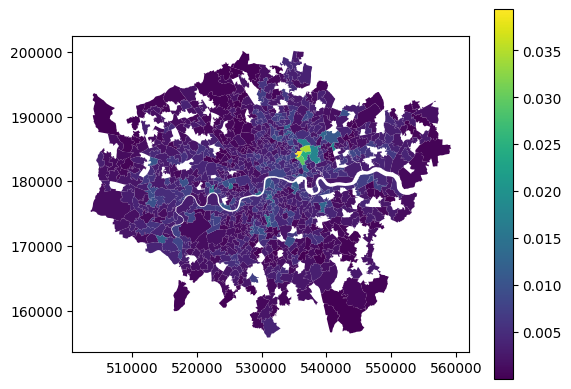

In [30]:
msoa_cycle.plot(
    column = 'cycle_density',
    legend = True
)

plt.show()

#### Casualty Density

<Axes: >

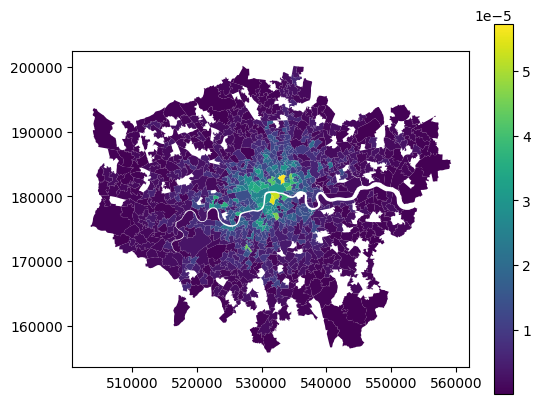

In [31]:
msoa_cycle.plot(
    column = 'casualty_density',
    legend = True
)

#### Active travel counts

In [32]:
traffic_counts = pd.DataFrame(msoa.sjoin(
    locations_gdf,
    predicate = 'intersects'
).groupby('MSOA11CD')['cycle_counts'].mean())

In [33]:
msoa_cycle = msoa_cycle.merge(traffic_counts, left_on = 'MSOA11CD', right_index = True)

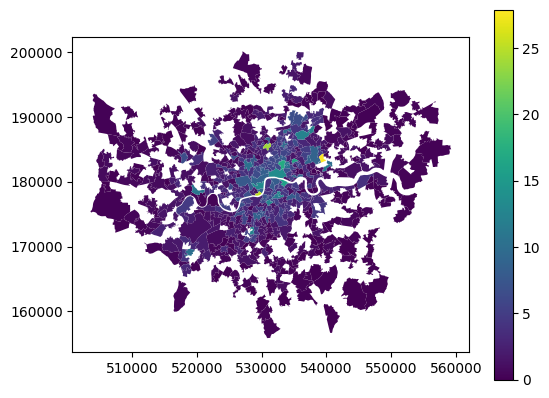

In [34]:
# plot count of cycle
msoa_cycle.plot(
    column = 'cycle_counts',
    legend = True
)

plt.show()

In [35]:
msoa_non0 = msoa_cycle[msoa_cycle['cycle_counts'] != 0].copy()

msoa_non0['casualty_per_cycle'] = msoa_non0['casualty_density'] * 1000000 / msoa_non0['cycle_counts']

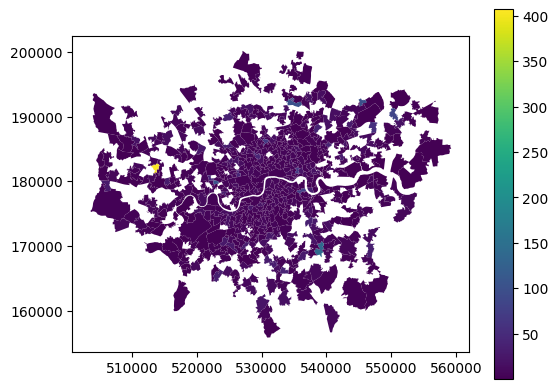

In [36]:
# plot count of cycle
msoa_non0.plot(
    column = 'casualty_per_cycle',
    legend = True
)

plt.show()

In [37]:
msoa_non0.to_file('data/msoa_cycling_data.gpkg', driver = 'GPKG')

#### Regression

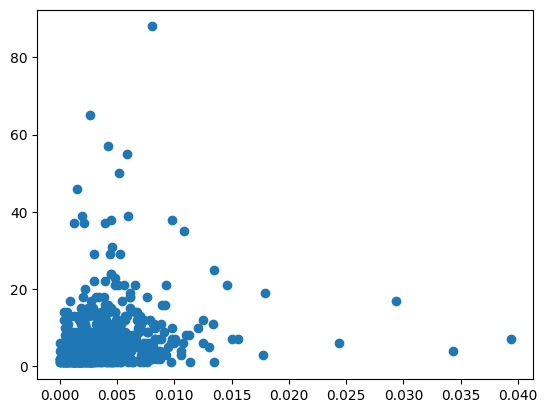

In [38]:
plt.scatter(
    x = msoa_cycle['cycle_density'],
    y = msoa_cycle['_Casualty Count']
)

In [39]:
msoa_cycle_dropna = msoa_cycle.dropna()

# run linear regression
model = sm.OLS(msoa_cycle_dropna['casualty_density'], sm.add_constant(msoa_cycle_dropna['cycle_density']))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       casualty_density   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     26.40
Date:                Fri, 23 Feb 2024   Prob (F-statistic):           3.75e-07
Time:                        10:00:50   Log-Likelihood:                 6150.5
No. Observations:                 605   AIC:                        -1.230e+04
Df Residuals:                     603   BIC:                        -1.229e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           6.23e-06   5.51e-07     11.304      0.000    5.15e-06    7.31e-06
cycle_density     0.0005      0.000      5.138      0.000       0.000       0.001
==============================================================================
Omnibus:                      237.032   Durbin-Watson:                   1.207
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              807.295
Skew:                           1.875   Prob(JB):                    4.99e-176
Kurtosis:                       7.239   Cond. No.                         273.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

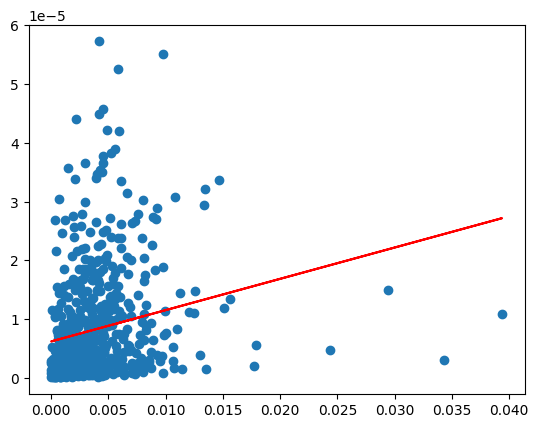

In [40]:
plt.scatter(
    x = msoa_cycle['cycle_density'],
    y = msoa_cycle['casualty_density']
)

plt.plot(
    msoa_cycle_dropna['cycle_density'], results.predict(sm.add_constant(msoa_cycle_dropna['cycle_density'])),
    color = 'red'
)

### Summarise by borough

In [41]:
# summarise casualties by borough

# load casualties for 2018 and 2022
casualty_2022 = pd.read_csv('data/jan-dec-2022-gla-data-extract-casualties.csv')
casualty_2018 = pd.read_csv('data/2018-data-files-casualty.csv')

# filter by casualty severity
casualty_2018 = casualty_2018[casualty_2018['Casualty Severity'] != '3 Slight'].copy()
casualty_2022 = casualty_2022[casualty_2022['_Casualty Severity'] != 'Slight'].copy()

# make a GeoPandas GeoDataFrame
casualty_2018_gdf = gpd.GeoDataFrame(
    casualty_2018,
    geometry = gpd.points_from_xy(casualty_2018['Easting'], casualty_2018['Northing'], crs = 'EPSG:27700')
)

casualty_2022_gdf = gpd.GeoDataFrame(
    casualty_2022,
    geometry = gpd.points_from_xy(casualty_2022['Easting'], casualty_2022['Northing'], crs = 'EPSG:27700')
)

# summarise by borough
casualty_boro_2018 = pd.DataFrame(
    boroughs.sjoin(
        casualty_2018_gdf,
        predicate = 'intersects'
    ).groupby('GSS_CODE')['No. of Casualties'].sum()
).rename(columns = {'No. of Casualties': 'casualty_2018'})

casualty_boro_2022 = pd.DataFrame(
    boroughs.sjoin(
        casualty_2022_gdf,
        predicate = 'intersects'
    ).groupby('GSS_CODE')['_Casualty Count'].sum()
).rename(columns = {'_Casualty Count': 'casualty_2022'})


In [42]:
# roads summarise by borough
boroughs_roads = pd.DataFrame(
    boroughs.sjoin(
        roads,
        predicate = 'intersects'
    ).groupby('GSS_CODE')['length'].sum()
)
boroughs_roads = boroughs_roads.rename(columns = {'length': 'road_network_length'})

In [43]:
# cycle routes
boroughs_cycle_routes = pd.DataFrame(
    boroughs.sjoin(
        cycle_routes[cycle_routes['Status'] == 'Open'],
        predicate = 'intersects',
        how = 'left'
    ).groupby('GSS_CODE')['Shape_Leng'].sum()
).rename(columns = {'Shape_Leng': 'cycle_route_length'})


In [44]:
# cycle active travel summarise by borough
boroughs_atc = pd.DataFrame(
    boroughs.sjoin(
        locations_gdf,
        predicate = 'intersects'
    ).groupby('GSS_CODE').cycle_counts.mean()
).rename(columns = {'cycle_counts': 'cycle_traffic_atc'})

In [45]:
# cycle lane data
boroughs_cycle_lanes = pd.DataFrame(boroughs.sjoin(cycle_lane, predicate = 'intersects').groupby('GSS_CODE').road_length.sum()).rename(columns = {'road_length': 'cycle_network_length'})

# cycle casualties_data
boroughs_cycle_casualties = pd.DataFrame(boroughs.sjoin(cycle_casualties, predicate = 'contains').groupby('GSS_CODE')['_Casualty Count'].sum()).rename(columns = {'_Casualty Count': 'cycle_casualties'})

# casualties_data
boroughs_casualties = pd.DataFrame(boroughs.sjoin(casualties, predicate = 'contains').groupby('GSS_CODE')['_Casualty Count'].sum()).rename(columns = {'_Casualty Count': 'all_casualties'})

# KSI data
boroughs_ksi = pd.DataFrame(boroughs.sjoin(ksi_casualties, predicate = 'contains').groupby('GSS_CODE')['_Casualty Count'].sum()).rename(columns = {'_Casualty Count': 'KSIs'})


# merge with original data frame
boroughs_cycle_data = boroughs.merge(
    boroughs_casualties, left_on = 'GSS_CODE', right_index = True
).merge(
    boroughs_cycle_casualties, left_on = 'GSS_CODE', right_index = True
).merge(
    boroughs_ksi, left_on = 'GSS_CODE', right_index = True
).merge(
    boroughs_cycle_routes, left_on = 'GSS_CODE', right_index = True
).merge(
    boroughs_cycle_lanes, left_on = 'GSS_CODE', right_index = True
).merge(
    boroughs_roads, left_on = 'GSS_CODE', right_index = True
).merge(
    london_traffic_pivot, left_on = 'GSS_CODE', right_index = True
).merge(
    boroughs_atc, left_on = 'GSS_CODE', right_index = True
).merge(
    casualty_boro_2018, left_on = 'GSS_CODE', right_index = True
).merge(
    casualty_boro_2022, left_on = 'GSS_CODE', right_index = True
)

In [46]:
boroughs_cycle_data.columns

Index(['NAME', 'GSS_CODE', 'HECTARES', 'NONLD_AREA', 'ONS_INNER', 'SUB_2009',
       'SUB_2006', 'geometry', 'all_casualties', 'cycle_casualties', 'KSIs',
       'cycle_route_length', 'cycle_network_length', 'road_network_length',
       'DfT_1993', 'DfT_1994', 'DfT_1995', 'DfT_1996', 'DfT_1997', 'DfT_1998',
       'DfT_1999', 'DfT_2000', 'DfT_2001', 'DfT_2002', 'DfT_2003', 'DfT_2004',
       'DfT_2005', 'DfT_2006', 'DfT_2007', 'DfT_2008', 'DfT_2009', 'DfT_2010',
       'DfT_2011', 'DfT_2012', 'DfT_2013', 'DfT_2014', 'DfT_2015', 'DfT_2016',
       'DfT_2017', 'DfT_2018', 'DfT_2019', 'DfT_2020', 'DfT_2021', 'DfT_2022',
       'cycle_traffic_atc', 'casualty_2018', 'casualty_2022'],
      dtype='object')

In [68]:
# normalise by area
boroughs_cycle_data['cycle_casualties_per_area'] = boroughs_cycle_data['cycle_casualties'] / boroughs_cycle_data.area
boroughs_cycle_data['all_casualties_per_area'] = boroughs_cycle_data['KSIs'] / boroughs_cycle_data.area
boroughs_cycle_data['cycle_lane_per_area'] = boroughs_cycle_data['cycle_network_length'] / boroughs_cycle_data.area
boroughs_cycle_data['cycle_route_per_area'] = boroughs_cycle_data['cycle_route_length'] / boroughs_cycle_data.area

# cycle network ratio to the road ratio
boroughs_cycle_data['cycle_network_ratio'] = boroughs_cycle_data['cycle_network_length'] / boroughs_cycle_data['road_network_length']

# normalise by traffic

# DfT data is vehicle / mile, so no need to do the normalisation before
# ATC is average density of traffic, so need to normalise by area
boroughs_cycle_data['cycle_casualties_per_vehicle_mile'] = boroughs_cycle_data['cycle_casualties'] / boroughs_cycle_data['DfT_2022'] * 1000000
boroughs_cycle_data['cycle_casualties_per_traffic_atc'] = boroughs_cycle_data['cycle_casualties_per_area'] / boroughs_cycle_data['cycle_traffic_atc']

boroughs_cycle_data['all_casualties_per_vehicle_mile'] = boroughs_cycle_data['KSIs'] / boroughs_cycle_data['DfT_2022'] * 1000000
boroughs_cycle_data['all_casualties_per_traffic_atc'] = boroughs_cycle_data['all_casualties_per_area'] / boroughs_cycle_data['cycle_traffic_atc']

# calculation of improvement ratio
boroughs_cycle_data['casualty_difference'] = np.log(boroughs_cycle_data['casualty_2022'] / boroughs_cycle_data['casualty_2018'])



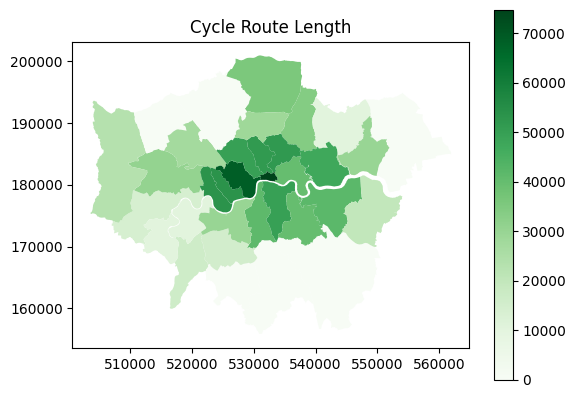

In [48]:
# plot casualties per area
boroughs_cycle_data.plot(
    column = 'cycle_route_length',
    legend = True,
    cmap = 'Greens'
)

plt.title('Cycle Route Length')

plt.show()

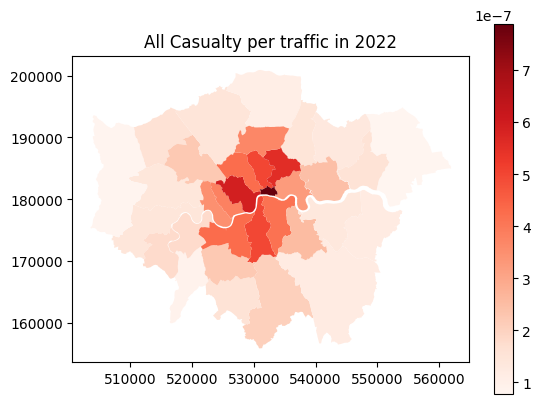

In [49]:
# plot casualties per area
boroughs_cycle_data.plot(
    column = 'all_casualties_per_vehicle_mile',
    legend = True,
    cmap = 'Reds'
)

plt.title('All Casualty per traffic in 2022')

plt.show()

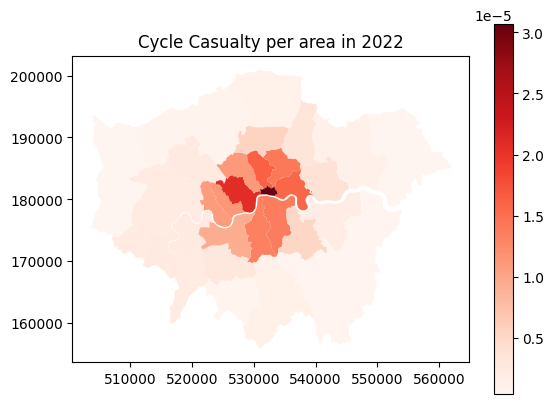

In [50]:
# plot casualties per area
boroughs_cycle_data.plot(
    column = 'cycle_casualties_per_area',
    legend = True,
    cmap = 'Reds'
)

plt.title('Cycle Casualty per area in 2022')

plt.show()

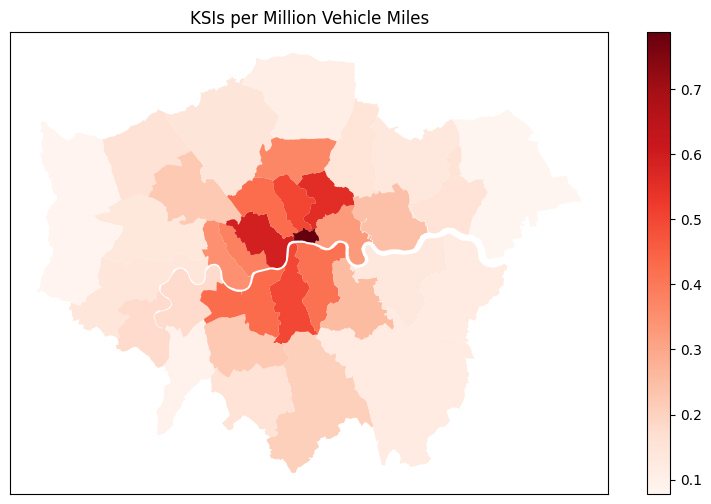

In [69]:
# initialise plot
f, ax = plt.subplots(1, 1, figsize = (10, 6))

# plot casualties per traffic
boroughs_cycle_data.plot(
    ax = ax,
    column = 'all_casualties_per_vehicle_mile',
    legend = True,
    cmap = 'Reds'
)

plt.xticks([])
plt.yticks([])

plt.title('KSIs per Million Vehicle Miles')

plt.savefig('plots/all_casualties_per_vehicle_mile.png', bbox_inches = 'tight')

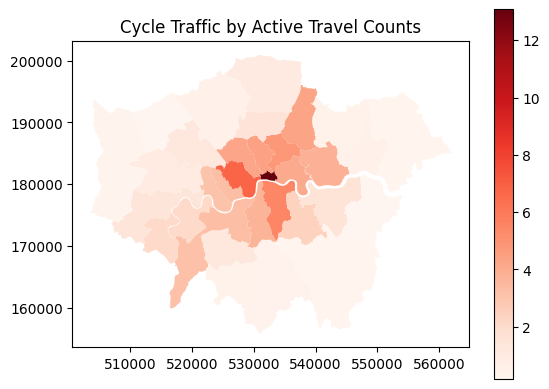

In [52]:
# plot cycling traffic
boroughs_cycle_data.plot(
    column = 'cycle_traffic_atc',
    legend = True,
    cmap = 'Reds'
)

plt.title('Cycle Traffic per Cycle ')


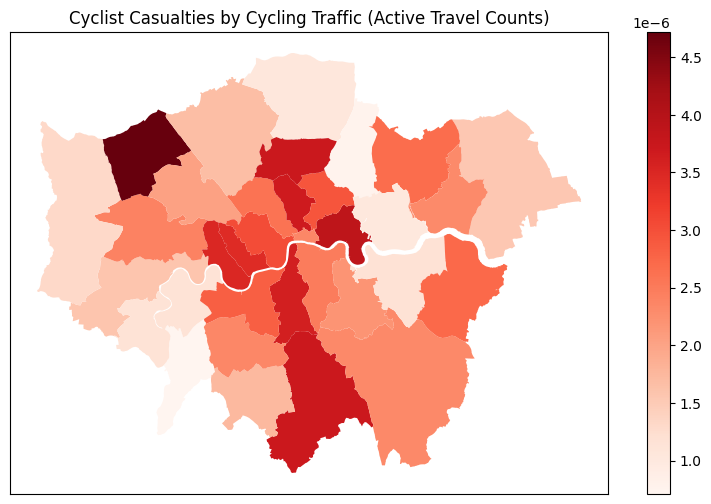

In [72]:
# initialise plot
f, ax = plt.subplots(1, 1, figsize = (10, 6))

# plot casualties per traffic
boroughs_cycle_data.plot(
    ax = ax,
    column = 'cycle_casualties_per_traffic_atc',
    legend = True,
    cmap = 'Reds'
)

plt.xticks([])
plt.yticks([])

plt.title('Cyclist Casualties by Cycling Traffic (Active Travel Counts)')

plt.savefig('plots/cycle_casualties_per_traffic.png', bbox_inches = 'tight')

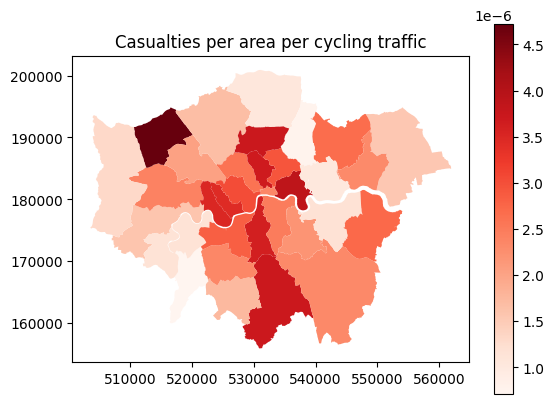

In [54]:
# plot casualties per traffic
boroughs_cycle_data.plot(
    column = 'cycle_casualties_per_traffic_atc',
    legend = True,
    cmap = 'Reds'
)

plt.title('Casualties per area per cycling traffic')

plt.show()

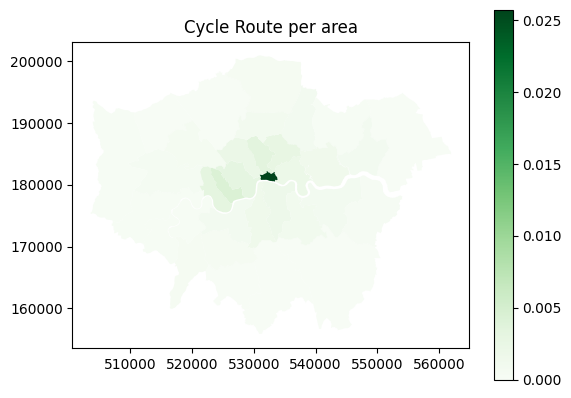

In [55]:
# plot cycle lane per area
boroughs_cycle_data.plot(
    column = 'cycle_route_per_area',
    legend = True,
    cmap = 'Greens'
)

plt.title('Cycle Route per area')

plt.show()

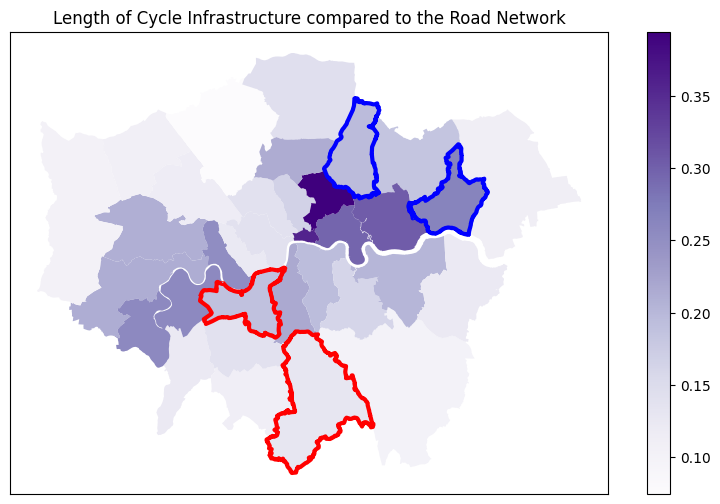

In [56]:
# initialise plot
f, ax = plt.subplots(1, 1, figsize = (10, 6))

# plot casualties per traffic
boroughs_cycle_data.plot(
    ax = ax,
    column = 'cycle_network_ratio',
    legend = True,
    cmap = 'Purples'
)

# define areas
good = ['Barking and Dagenham', 'Waltham Forest']
bad = ['Croydon', 'Wandsworth']

for b in good:
    boroughs[boroughs['NAME'] == b].plot(
        ax = ax,
        facecolor = 'None',
        edgecolor = 'blue',
        linewidth = 3
    )

for b in bad:
    boroughs[boroughs['NAME'] == b].plot(
        ax = ax,
        facecolor = 'None',
        edgecolor = 'red',
        linewidth = 3
    )
    
plt.title('Length of Cycle Infrastructure compared to the Road Network')

# delete axis ticks
plt.xticks([])
plt.yticks([])

# save figure
plt.savefig('plots/cycle_infrastructure.png', bbox_inches = 'tight')

[]

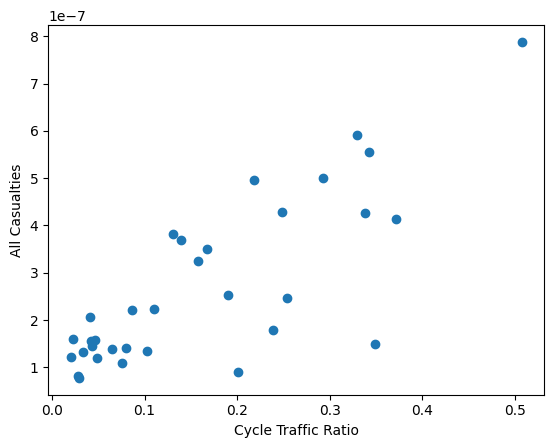

In [57]:
plt.scatter(
    x = boroughs_cycle_data['cycle_traffic_atc'] / (boroughs_cycle_data['DfT_2022'] / boroughs_cycle_data.area),
    y = boroughs_cycle_data['all_casualties_per_vehicle_mile']
)

plt.xlabel('Cycle Traffic Ratio')
plt.ylabel('All Casualties')

plt.plot()

[]

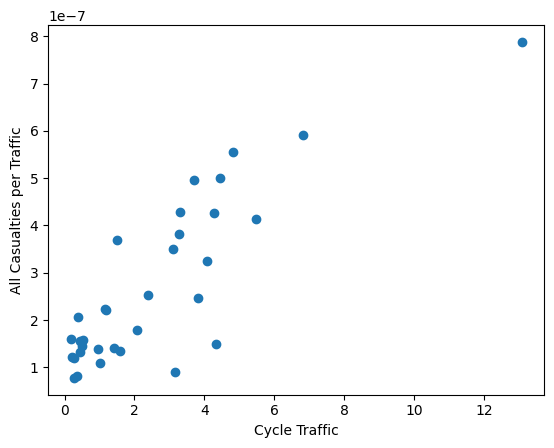

In [58]:
plt.scatter(
    x = boroughs_cycle_data['cycle_traffic_atc'],
    y = boroughs_cycle_data['all_casualties_per_vehicle_mile']
)

plt.xlabel('Cycle Traffic')
plt.ylabel('All Casualties per Traffic')

plt.plot()

[]

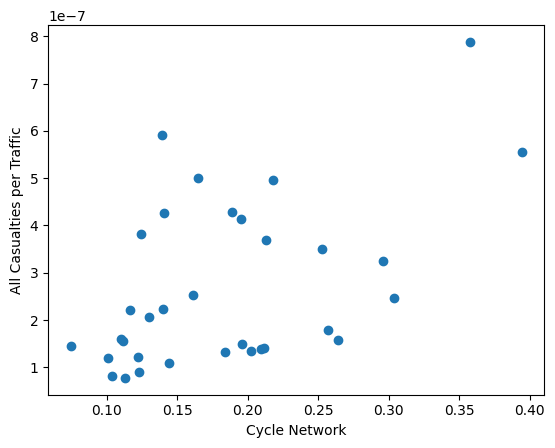

In [61]:
plt.scatter(
    x = boroughs_cycle_data['cycle_network_ratio'],
    y = boroughs_cycle_data['all_casualties_per_vehicle_mile']
)

plt.xlabel('Cycle Network')
plt.ylabel('All Casualties per Traffic')

plt.plot()

[]

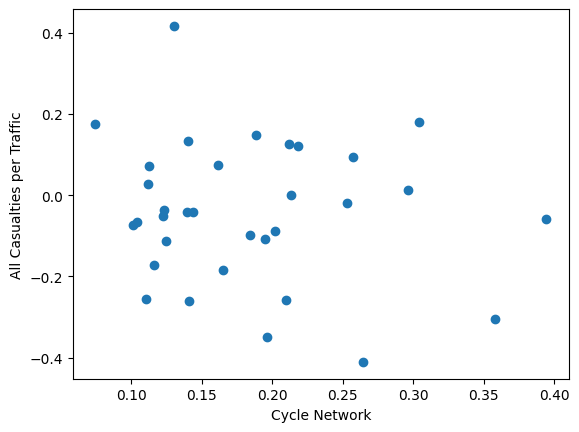

In [62]:
plt.scatter(
    x = boroughs_cycle_data['cycle_network_ratio'],
    y = boroughs_cycle_data['casualty_difference']
)

plt.xlabel('Cycle Network')
plt.ylabel('All Casualties per Traffic')

plt.plot()

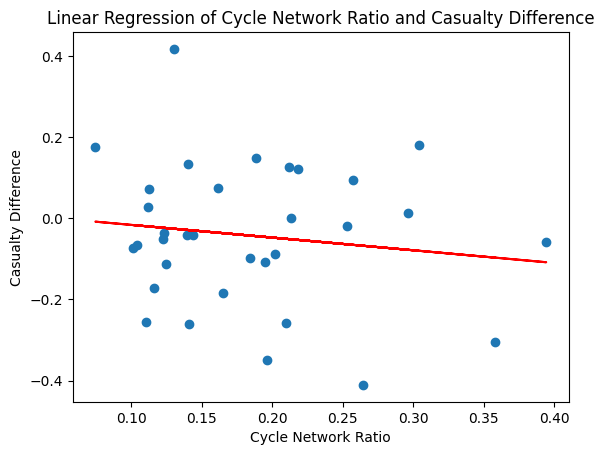

In [63]:
# run linear regression
model = sm.OLS(boroughs_cycle_data['casualty_difference'], sm.add_constant(boroughs_cycle_data['cycle_network_ratio']))
results = model.fit()

plt.scatter(
    x = boroughs_cycle_data['cycle_network_ratio'],
    y = boroughs_cycle_data['casualty_difference']
)

# Use the predicted values from the regression for the plot
plt.plot(
    boroughs_cycle_data['cycle_network_ratio'], results.predict(sm.add_constant(boroughs_cycle_data['cycle_network_ratio'])),
    color = 'red'
)

# Add labels and title
plt.xlabel('Cycle Network Ratio')
plt.ylabel('Casualty Difference')
plt.title('Linear Regression of Cycle Network Ratio and Casualty Difference')

# Show the plot
plt.show()


In [64]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     casualty_difference   R-squared:                       0.019
Model:                             OLS   Adj. R-squared:                 -0.013
Method:                  Least Squares   F-statistic:                    0.6006
Date:                 Fri, 23 Feb 2024   Prob (F-statistic):              0.444
Time:                         10:04:56   Log-Likelihood:                 11.556
No. Observations:                   33   AIC:                            -19.11
Df Residuals:                       31   BIC:                            -16.12
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0150      0.080      0.186      0.853      -0.149       0.179
cycle_network_ratio    -0.3130      0.404     -0.775      0.444      -1.137       0.511
==============================================================================
Omnibus:                        0.298   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.862   Jarque-Bera (JB):                0.098
Skew:                           0.131   Prob(JB):                        0.952
Kurtosis:                       2.945   Cond. No.                         13.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""